# Prelimary Modelling

This file is part of the Glaucoma Phenotype ML Estimation project.

 Glaucoma Phenotype ML Estimation is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.


The Glaucoma Phenotype ML Estimation project is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with the Glaucoma Phenotype ML Estimation project.  If not, see <http://www.gnu.org/licenses/>.


### Goals:
1. Create some baseline models of the regression task, or classification? see which one might do better
2. use raw unprocessed data


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
import pickle as pkl
import os
from pathlib import Path
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
import zipfile
#import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision import *
from PIL import Image
from torch import tensor

from glaucoma.helpers.glaucoma_helpers import is_number, parse_files, return_uniq_index, return_duplicates, plot_idx, split_unzipped

In [6]:
from fastai.distributed import *

### Set these as required

In [15]:
##### PLEASE SET AS REQUIRED########
WORKING_DIR = Path(os.getcwd())
DATA_DIR = WORKING_DIR / 'data'
META_DIR = DATA_DIR / 'metadata'
TRAIN_DIR = DATA_DIR /"train"

as we can see some images here are different size

In [8]:
unzipped_files = parse_files(str(DATA_DIR / "unzipped"))

In [9]:
normal = (1040,800)
diff_size = []
diff_set = []
diff_batch = []
for file in unzipped_files:
    img = Image.open(file)
    if img.size != normal:
        diff_batch.append(file.split(os.path.sep)[-2])
        diff_size.append(file)
        diff_set.append(img.size)

In [20]:
set(diff_batch)

{'Alex_Jamie_802_white_set',
 'L_61Left',
 'L_62Right',
 'L_94Left',
 'L_95Right',
 'L_haveCDRnoDD',
 'set_A',
 'set_B',
 'set_C',
 'set_D'}

## Fast ai modelling

In [19]:
path_img = TRAIN_DIR

In [21]:
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_func(lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2],label_cls=FloatList)
tfms = get_transforms() # or tfms=None if none are needed
size=(800,1040) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)

In [ ]:
data = (ImageList.from_folder(str(path_img))
        .split_by_rand_pct(seed=42)
        .label_from_func(lambda o: float((o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2]))
        .transform(get_transforms())
        .databunch()
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(3, figsize=(10,10), hide_axis=False)

In [10]:
# Running a basic image net
learn = cnn_learner(data,models.resnet34)

In [28]:
class MSELossFlat(nn.MSELoss): 
#“Same as `nn.MSELoss`, but flattens input and target.”
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [27]:
class L1LossFlat(nn.L1Loss):
#Mean Absolute Error Loss”
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [26]:
learn.data.batch_size = 20

In [21]:
#use two gpus
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1])
#learn =learn.to_distributed()

In [29]:
# Change loss funtion
learn.loss = MSELossFlat

In [ ]:
#load model
#learn.load('g_model_7e')
#learn.load("g_model_e3_stage_2")

In [42]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [12]:
learn.metrics =[accuracy]

In [29]:
min_grad_lr = 6.10E-03

In [37]:
learn.fit_one_cycle(3,slice(min_grad_lr))

epoch,train_loss,valid_loss,time
0,1.883020,1.652890,30:49
1,1.614780,2.703503,30:59
2,1.509261,1.411530,31:17


In [43]:
learn.export(WORKING_DIR / "glaucoma_model_stage2.pkl")

In [ ]:
#fine tuning

In [30]:
learn.unfreeze()

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


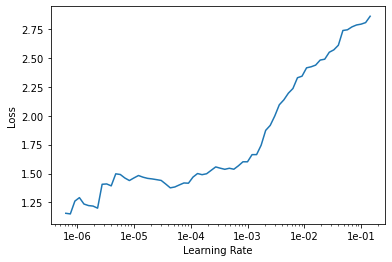

In [32]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(cyc_len=3, max_lr=slice(6e-7,1e-5))

epoch,train_loss,valid_loss,time


## Prediction and results

In [193]:
preds = learn.get_preds()

In [194]:
root_mean_squared_error(preds[0],preds[1])

tensor(1.0870)

In [195]:
mean_absolute_error(*preds)

tensor(0.8092)

In [196]:
exp_rmspe(*preds)

tensor(6.9904)

In [143]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [37]:
r2_score(*preds)

tensor(0.6592)

In [88]:
bb = preds[0].t().numpy()[0]

In [140]:
def categorical_convert_metrics(preds):
    y = preds[1] *2
    y_hat = preds[0].t().numpy()[0]
    #round up to closest bin:
    y_hat_round = torch.reshape(tensor([round(float(num*2))/2. for num in y_hat]),(-1,1)) *2 
    acc = accuracy_score(y_hat_round,y)
    print("accuracy: " +str(acc))
    return y_hat_round, y
    
    

In [141]:
y_h, y = categorical_convert_metrics(preds)

accuracy: 0.22005829358770534


In [146]:
cm_mat = confusion_matrix(y,y_h)

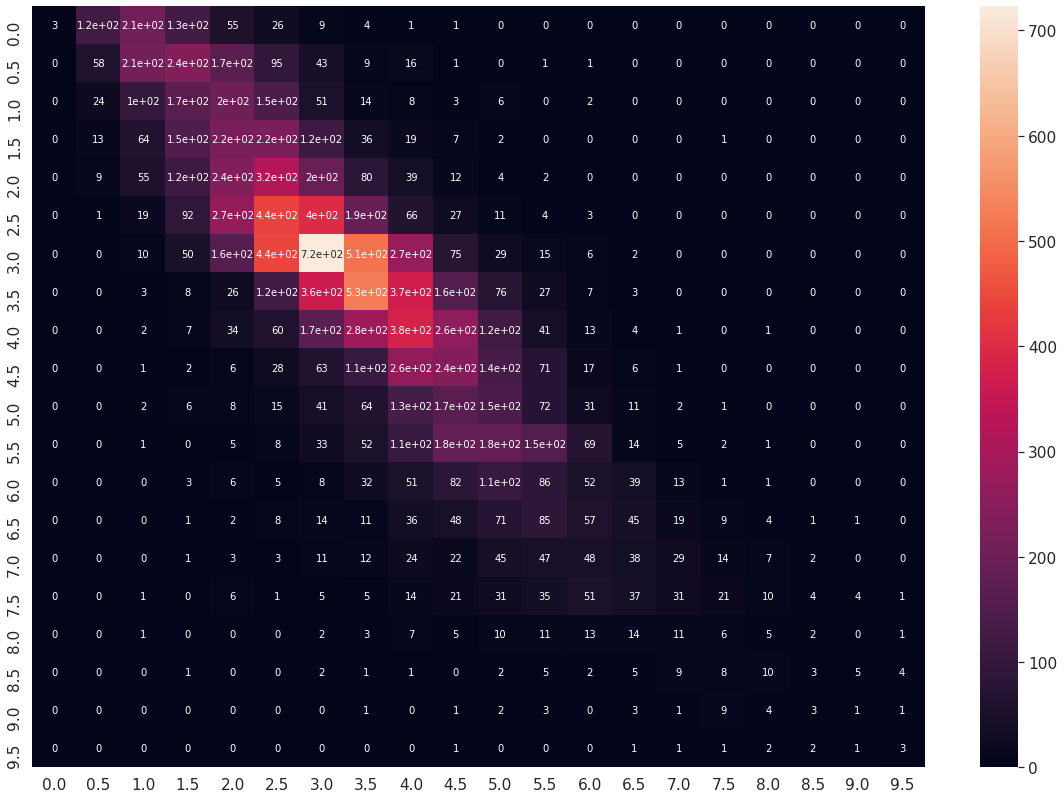

In [159]:
df_cm = pd.DataFrame(cm_mat, np.asarray(range(20))/2, np.asarray(range(20))/2)
plt.figure(figsize=(20,14))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

# calculating accuracy with a given acceptance threshold

In [161]:
y_hat= preds[0].t().numpy()[0]

In [186]:
pm_thres = 2.01
correct = 0
for i,truth in enumerate(preds[1]):
    if y_hat[i] > truth - pm_thres and y_hat[i] < truth + pm_thres:
        correct +=1
    

In [187]:
correct / len(y_hat)

0.9346184419713831

In [32]:
from fastai.torch_core import flatten_model
from fastai.layers import CrossEntropyFlat


def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

## Resnest model testing

In [7]:
from resnest.torch import resnest50
model = resnest50(pretrained=True)

Downloading: "https://hangzh.s3.amazonaws.com/encoding/models/resnest50-528c19ca.pth" to /home/jovyan/.cache/torch/checkpoints/resnest50-528c19ca.pth


In [24]:
from fastai.vision.models import *
from fastai.vision.learner import model_meta

In [30]:
learn = cnn_learner(data,resnest_50)

In [35]:
arch_summary(models.resnet50)

(0) Conv2d      : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) ReLU        : 1   layers (total: 3)
(3) MaxPool2d   : 1   layers (total: 4)
(4) Sequential  : 23  layers (total: 27)
(5) Sequential  : 30  layers (total: 57)
(6) Sequential  : 44  layers (total: 101)
(7) Sequential  : 23  layers (total: 124)
(8) AdaptiveAvgPool2d: 1   layers (total: 125)
(9) Linear      : 1   layers (total: 126)


In [34]:
arch_summary(resnest_50)

(0) Conv2d      : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) ReLU        : 1   layers (total: 3)
(3) Conv2d      : 1   layers (total: 4)
(4) BatchNorm2d : 1   layers (total: 5)
(5) ReLU        : 1   layers (total: 6)
(6) Conv2d      : 1   layers (total: 7)
(7) BatchNorm2d : 1   layers (total: 8)
(8) ReLU        : 1   layers (total: 9)
(9) MaxPool2d   : 1   layers (total: 10)
(10) Sequential  : 39  layers (total: 49)
(11) Sequential  : 52  layers (total: 101)
(12) Sequential  : 76  layers (total: 177)
(13) Sequential  : 40  layers (total: 217)
(14) GlobalAvgPool2d: 1   layers (total: 218)
(15) Linear      : 1   layers (total: 219)


In [33]:
get_groups(nn.Sequential(*learn.model[0], *learn.model[1]), learn.layer_groups)


Group 1: ['Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'MaxPool2d', 'Sequential', 'Sequential', 'Sequential', 'Sequential']
Group 2: ['AdaptiveConcatPool2d', 'Flatten', 'BatchNorm1d', 'Dropout', 'Linear', 'ReLU', 'BatchNorm1d', 'Dropout', 'Linear']


In [29]:
def resnest_50(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = resnest50(pretrained=True)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[0], *all_layers[1:])

## management

In [22]:
torch.cuda.empty_cache()

In [64]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable
